# Higher-Order Regression

In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [26]:
class HigherOrderRegressor():
    def __init__(self, degree):
        self.degree = degree
        self.X = None
        self.Y = None
        self.B = None
        self.num_features = None

    def fit(self, X, Y):
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        if len(Y.shape) == 1:
            Y = Y.reshape(-1, 1)
        self.num_features=X.shape[1]
        indices=np.random.shuffle(np.arange(X.shape[0]))
        temp_X = X[indices][0]
        temp_Y = Y[indices][0]
        # np.hstack((np.ones((self.X.shape[0], 1)), self.X))
        self.orig_X = np.hstack((np.ones((X.shape[0], 1)), temp_X))
        self.Y = temp_Y
        self.X = self.recursive_generate_powers(0, self.degree, np.ones(X.shape[0])).T
        try:
            self.B = np.matmul(np.linalg.pinv(np.matmul(self.X.T, self.X)),
                                np.matmul(self.X.T, self.Y))
        except:
            self.B = np.matmul(np.linalg.pinv(np.matmul(self.X.T, self.X)),
                                np.matmul(self.X.T, self.Y))

    def recursive_generate_powers(self, max_feature_encountered, current_degree, current_product, use_orig=True):
        if current_degree == 0:
            return current_product
        result=[]
        for i in range(max_feature_encountered, self.num_features+1):
            if use_orig:
                result.append(self.recursive_generate_powers(i, current_degree-1,
                                                            current_product*self.orig_X[:,i]))
            else:
                result.append(self.recursive_generate_powers(i, current_degree-1,
                                                            current_product*self.test_X[:,i], False))
        result=np.vstack(result)
        return result
    
    def predict(self, X):
        self.test_X=np.hstack((np.ones((X.shape[0], 1)), X.reshape(-1,1)))
        self.final_testX=self.recursive_generate_powers(0, self.degree, np.ones(X.shape[0]), False).T
        return np.matmul(self.final_testX, self.B)

    def sum_of_squares(self, Y_true, Y_pred):
        return np.sum((Y_true - Y_pred)**2)
        
    def r2_score(self, Y_true, Y_pred):
        return 1 - np.sum((Y_true - Y_pred)**2) / np.sum((Y_true - np.mean(Y_true))**2)

    def k_fold_testing(self, k=10):
        width = self.X.shape[0]//k
        average_r2 = 0
        count = 0
        for i in range(0, self.X.shape[0], k):
            count += 1
            X_train = np.concatenate((self.X[:i], self.X[i+width:]))
            Y_train = np.concatenate((self.Y[:i], self.Y[i+width:]))
            X_test = self.X[i:i+width]
            Y_test = self.Y[i:i+width]
            try:
                B = np.matmul(np.linalg.pinv(np.matmul(X_train.T, X_train)), np.matmul(X_train.T, Y_train))
            except:
                B = np.matmul(np.linalg.pinv(np.matmul(X_train.T, X_train)), np.matmul(X_train.T, Y_train))
            predictions = np.matmul(X_test, B)
            average_r2 += self.r2_score(Y_test, predictions)
        # print(self.X.shape)
        try:
            B = np.matmul(np.linalg.pinv(np.matmul(self.X.T, self.X)), np.matmul(self.X.T, self.Y))
        except:
            B = np.matmul(np.linalg.pinv(np.matmul(self.X.T, self.X)), np.matmul(self.X.T, self.Y))
        return average_r2/count, np.matmul(self.X, B)
    
    def cross_validation(self, params):
        maximum_param=np.max(params)
        self.max_X=self.recursive_generate_powers(0, maximum_param, np.ones(self.X.shape[0])).T
        # print(self.max_X)
        responses = []
        factorials=[1]
        for i in range(1, maximum_param+self.num_features+1):
            factorials.append(factorials[-1]*i)
        for param in params:
            self.degree = param
            # print((factorials[param+self.num_features]//factorials[self.num_features])//factorials[param])
            self.X=self.max_X[:,:(factorials[param+self.num_features]//factorials[self.num_features])//factorials[param]]
            response, plot_values = self.k_fold_testing()
            responses.append(response)
            fig=plt.figure()
            plt.scatter(self.orig_X[:,1], self.Y)
            indices=np.argsort(self.orig_X[:,1])
            plt.plot(self.orig_X[:,1][indices], plot_values[indices], 'red')
            fig.savefig(f"degree_{param}.png")
        print(responses)
    
    def write_params(self):
        with open("3_weights.pkl", "wb") as f:
            pickle.dump(self.B, f)


In [4]:
train_data=pd.read_csv('train.csv')

In [5]:
X=train_data['x'].to_numpy()
Y=train_data['y'].to_numpy()

In [15]:
regressor=HigherOrderRegressor(3)

In [16]:
regressor.fit(X,Y)

In [113]:
test_data=pd.read_csv('test.csv')

In [114]:
X_test=test_data['x'].to_numpy()

In [14]:
regressor2=HigherOrderRegressor(3)

In [17]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

NameError: name 'train_test_split' is not defined

In [74]:
regressor.fit(X_train,Y_train)

In [75]:
data=regressor.predict(X_val)

In [76]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [77]:
r2_score(Y_val, data)

0.8776829081113265

In [78]:
mean_squared_error(Y_val, data)

819.8538414941444

In [79]:
mean_absolute_error(Y_val, data)

22.557238245353524

In [102]:
regressor.cross_validation([2,3,4,5,6,7,8,9,10])

[0.7405248627800795, 0.8110940468157531, 0.885533449535035, 0.8890032715554141, 0.8890277101115677, 0.888332487004736, 0.887539875919861, 0.8879689135086817, 0.8869996684551753]


In [164]:
regressor.cross_validation([2,3,4,5,6,7,8,9,10])

[56427.175480097954, 39251.2107718163, 24080.14499184062, 23135.01264391381, 23147.39205431092, 23316.53520429746, 23507.28378862272, 23391.932968519566, 23591.837720512074]


In [168]:
regressor3=HigherOrderRegressor(5)

In [169]:
regressor3.fit(X,Y)

In [170]:
regressor3.write_params()

In [171]:
test_data=pd.read_csv('test.csv')
X_test=test_data['x'].to_numpy()
test_data['y']=regressor3.predict(X_test)

[0.7405248627800795, 0.8110940468157531, 0.8855334495350349]


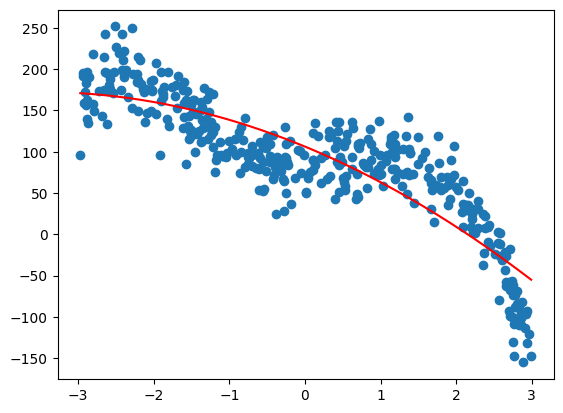

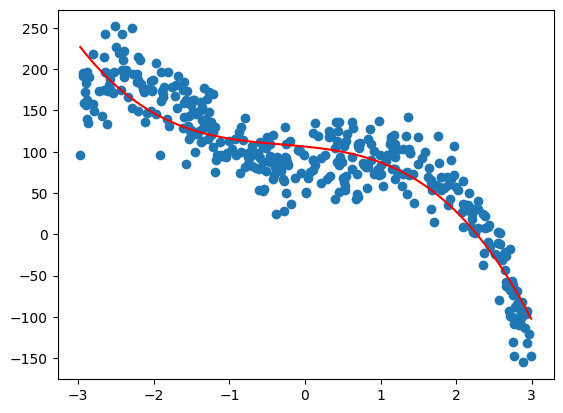

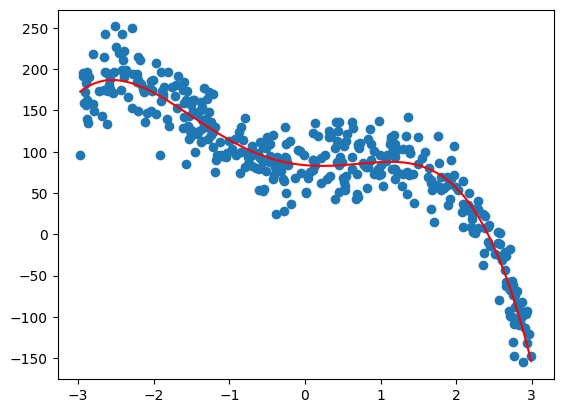

In [287]:
regressor=HigherOrderRegressor(5)
regressor.fit(X, Y)
regressor.cross_validation([2,3,4])

In [247]:
regressor.fit(X,Y)

[[ 1.00000000e+00  4.33511435e-01  1.87932164e-01  8.14707421e-02
   3.53184983e-02]
 [ 1.00000000e+00 -1.44346461e+00  2.08359009e+00 -3.00758857e+00
   4.34134767e+00]
 [ 1.00000000e+00 -1.88092790e-01  3.53788977e-02 -6.65451558e-03
   1.25166640e-03]
 ...
 [ 1.00000000e+00  4.87637236e-01  2.37790074e-01  1.15955294e-01
   5.65441192e-02]
 [ 1.00000000e+00 -2.22644221e+00  4.95704493e+00 -1.10365741e+01
   2.45722945e+01]
 [ 1.00000000e+00 -1.80002085e+00  3.24007506e+00 -5.83220267e+00
   1.04980864e+01]]
[[1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 

ValueError: x and y can be no greater than 2D, but have shapes (400, 2, 2) and (400, 2, 1)

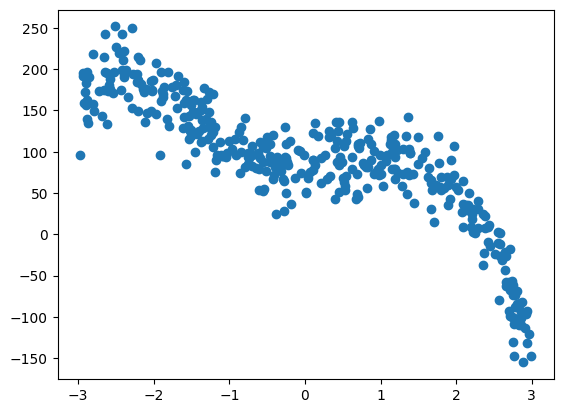

In [248]:
regressor.cross_validation([2,3,4])

In [22]:
reg=HigherOrderRegressor(5)

In [23]:
reg.fit(X, Y)

In [25]:
reg.r2_score(Y, reg.predict(X))

-761.3155245589338

In [20]:
np.hstack((np.ones((X.shape[0], 1)), X.reshape(-1,1)))    

array([[ 1.        ,  0.43351143],
       [ 1.        , -1.44346461],
       [ 1.        , -0.18809279],
       [ 1.        ,  2.64125814],
       [ 1.        , -0.37447673],
       [ 1.        , -2.59155556],
       [ 1.        , -1.21537829],
       [ 1.        , -0.75498012],
       [ 1.        ,  2.76500795],
       [ 1.        ,  2.08804938],
       [ 1.        , -0.97104629],
       [ 1.        ,  2.350638  ],
       [ 1.        ,  0.91920492],
       [ 1.        ,  2.78197656],
       [ 1.        ,  1.49272955],
       [ 1.        , -1.52362089],
       [ 1.        , -2.03676707],
       [ 1.        , -0.91659889],
       [ 1.        ,  2.94203368],
       [ 1.        ,  1.38073218],
       [ 1.        , -1.55148828],
       [ 1.        , -0.81773537],
       [ 1.        ,  0.41978946],
       [ 1.        , -0.24837623],
       [ 1.        , -1.48835407],
       [ 1.        ,  0.52070608],
       [ 1.        , -1.53344645],
       [ 1.        , -1.03979471],
       [ 1.        ,

In [19]:
X.shape

(400,)